# Evaluating Bias

The purpose of my project was to create a model which shows signs of less bias than standard models. Evaluating the level of bias in my case can be determined if a model performs extremely well in images from one category, but then performs poorly on another category (usually the under-represented group). 

This is why the images were separated into categories based on a specific feature that they showed. By getting the accuracies of both models, namely the LatentNet and DCNN, I could conduct statistical tests to determine which showed more bias. 

# Creating Test Categories

Images were split into 4 groups.

1. High Hair Density
2. Type I Fitzpatrick Scale
3. Type II Fitzpatrick Scale
4. Type III Fitzpatrick Scale

**Fitzpatrick Scale**

A system used to classify types of skin. The scale is not purely based on skin color, but generally follows the pattern that Type I is the lightest and Type VI is the darkest. 

<img src="images/Type1-6.png" alt="Drawing" style="width: 25;"/>  

***Only the first 3 are considered*** because Melanoma is extremely unlikely in Type 4 to 6 patients. Type 4 to 6 skin often contains a pigment known as *eumelanin* which provides extra protection against UV radiation.  

By evaluating the performance in each of these categories, we can see if and how the LatentNet improved accuracy in images with specific variations of skin features related to skin color and hair density. 

In this notebook, we will simulate the process of identifying which particular Fitzpatrick scale each image can be approximately classified into. Furthermore, we will demonstrate our the computer vision algorithm which provides a quantitative measure for the amount of hair in a dermoscopic image. 

In [1]:
import cv2
import os
import numpy as np
import tensorflow.keras.preprocessing.image as tfimg
import matplotlib.pyplot as plt

## Detecting Hair
Method ```high_hair_density``` returns a boolean value signifying if the approximate density was greater than 0.07. 

In [2]:
def high_hair_density(image_path):
    image = cv2.imread(image_path)
    grayScale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(1,(17,17))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    num = cv2.countNonZero(threshold)
    size = threshold.shape[0]*threshold.shape[1]
    f, axarr = plt.subplots(1, 3, figsize=(12, 12))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axarr[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.grid(False)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].set_title('Original Image')
    axarr[1].imshow(grayScale, plt.cm.binary)
    plt.grid(False)
    axarr[1].set_xticks([])
    axarr[1].set_yticks([])
    axarr[1].set_title('Grayscale Image')
    axarr[2].imshow(threshold)
    plt.grid(False)
    axarr[2].set_xticks([])
    axarr[2].set_yticks([])
    axarr[2].set_title(f'Binary Hair Image, Density={round(num/size, 2)}')
    return num/size >= 0.07

### Test Image 1

The following image is a sample non-melanoma image which was used during validation. The 3 images in the plot show the process of the computer vision algorithm which calculates *approximate* hair density. 

Contains high hair density: True


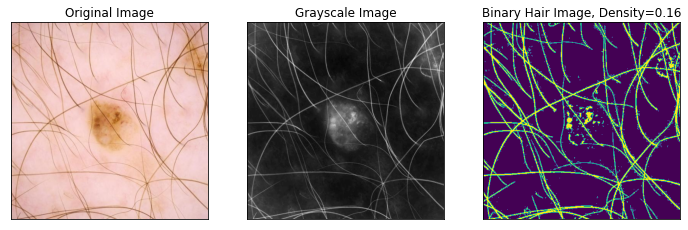

In [3]:
sample_img_1 = r'C:\Luna_CS\Melanoma 2020\---Full Validation Sets---\Hair Density\Normal\ISIC_0164145.jpg'
print(f'Contains high hair density: {high_hair_density(sample_img_1)}')

### Test Image 2
This image is a melanoma image with high hair density. 

Contains high hair density: True


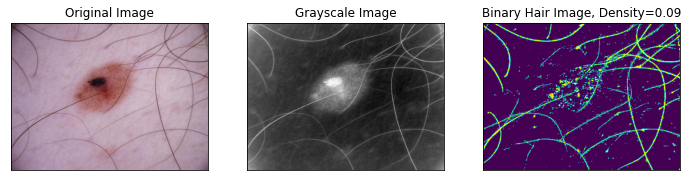

In [4]:
sample_img_2 = r'C:\Luna_CS\Melanoma 2020\---Full Validation Sets---\Hair Density\Melanoma\ISIC_0034087.jpg'
print(f'Contains high hair density: {high_hair_density(sample_img_2)}')

### Test Image 3

This last sample image falls in the non-melanoma, however, this one does *not* have a high hair density. 

Contains high hair density: False


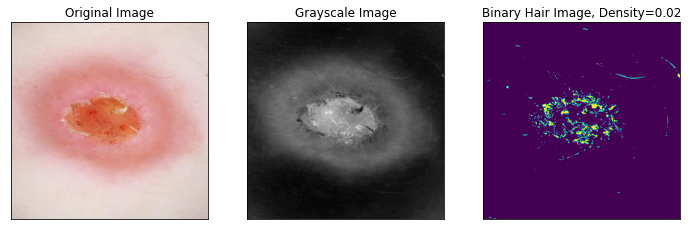

In [5]:
sample_img_3 = r'C:\Luna_CS\Melanoma 2020\---Normal Validation Set---\ISIC_0168306.jpg'
print(f'Contains high hair density: {high_hair_density(sample_img_3)}')

As you may notice, the algorithm is not perfect. It still did detect some pixels as hair even though they really were not. This is why we have set the threshold for the density to be greater than or equal to 0.07. This leaves enough room for the algorithm to ignore mis-detections of hair such as those in this image.

## Approximating Fitzpatrick Scale

These images are not labelled with their Fitzpatrick Scale. To classify the images, the method below called ```fitzpatrick_scale_id``` approximates whether an image best falls into Type I, II, or III.



In [6]:
def fitzpatrick_scale_id(key, full_path=False, show=True):
    test_img = r'C:\Luna_CS\Melanoma 2020\val_mel\ISIC_00{key}.jpg'.format(key=key)
    f, axarr = plt.subplots(1, 5, figsize=(12, 12))
    if full_path: test_img = key
    img = cv2.imread(test_img)
    if show:
        axarr[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.grid(False)
        axarr[0].set_xticks([])
        axarr[0].set_yticks([])
        axarr[0].set_title('Original')
    blur = cv2.blur(img,(50,50))
    if show:
        axarr[1].imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))
        plt.grid(False)
        axarr[1].set_xticks([])
        axarr[1].set_yticks([])
        axarr[1].set_title('Blurred')
    
    lows = {'Type I': np.array([180, 180, 0]), 'Type II': np.array([150, 150, 0]), 'Type III': np.array([80, 80, 0])}
    highs = {'Type I': np.array([255, 255, 255]), 'Type II': np.array([200, 200, 255]), 'Type III': np.array([150, 150, 255])}
    max_black = 0
    label = None
    ind = 2
    for color in lows.keys():
        mask = cv2.inRange(blur, lows[color], highs[color])
        res = cv2.bitwise_and(blur, blur, mask=mask)
        res_black = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
        num = cv2.countNonZero(res_black)
        if num > max_black:
            max_black = num
            label = color
        if show:
            axarr[ind].imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
            plt.grid(False)
            axarr[ind].set_xticks([])
            axarr[ind].set_yticks([])
            axarr[ind].set_title(color)
            ind+=1
    return label if label != None else 'Other'

#### How it works

1. The image is first blurred to remove unnecessary noise from the background. This will provide more attention on the *overall skin color* rather than minute details.
2. Three constant, pre-defined masks corresponding to Type I, II, and III of the Fitzpatrick Scale are applied to the image.
3. From each resulting masked image, the mask that results in the most remaining pixels (i.e. non-black) is the classified Fitzpatrick Scale.

## Test Image 1

The following dermoscopic image is a Melanoma lesion and falls in the Type 1 category. 

Approximate Category: Type I


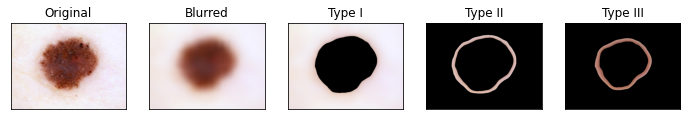

In [7]:
sample_img_1 = r'C:\Luna_CS\Melanoma 2020\---Full Validation Sets---\Skin Type\Melanoma\Type I\ISIC_0026207.jpg'
print(f'Approximate Category: {fitzpatrick_scale_id(sample_img_1, full_path=True, show=True)}')

Approximate Category: Type II


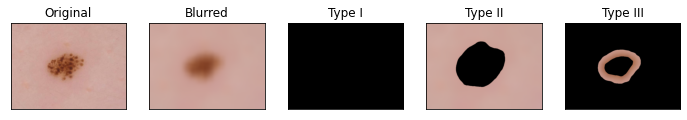

In [8]:
sample_img_2 = r'C:\Luna_CS\Melanoma 2020\---Full Validation Sets---\Skin Type\Melanoma\Type II\ISIC_0025724.jpg'
print(f'Approximate Category: {fitzpatrick_scale_id(sample_img_2, full_path=True, show=True)}')

Approximate Category: Type III


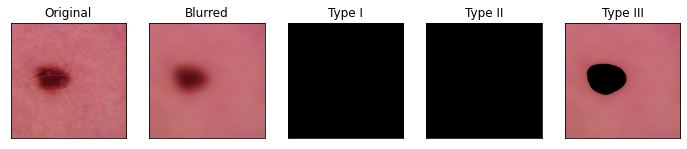

In [9]:
sample_img_3 = r'C:\Luna_CS\Melanoma 2020\---Normal Validation Set---\ISIC_0084395.jpg'
print(f'Approximate Category: {fitzpatrick_scale_id(sample_img_3, full_path=True, show=True)}')

The above examples were perfect in the sense that all background skin pixels were highlighted. However, this is not always the case. Our algorithm simply classifies the image based on where *most* of the pixels lie. 

Approximate Category: Type II


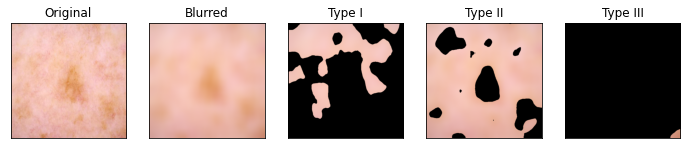

In [10]:
sample_img_4 = r'C:\Luna_CS\Melanoma 2020\---Normal Validation Set---\ISIC_0180510.jpg'
print(f'Approximate Category: {fitzpatrick_scale_id(sample_img_4, full_path=True, show=True)}')

### End